# Packages

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture
!pip install recordlinkage
!pip instal transformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim 
from gensim import models
import numpy as np
import nltk
from ast import literal_eval
#import ppmi
import bert_utils
import regex as re
from recordlinkage.preprocessing import clean
import recordlinkage

ModuleNotFoundError: ignored

# Load, clean and explore datasets

## Billboard & Spotify Data

In [ ]:
import os
os.getcwd()

'/Users/hzx/Desktop/MACSThesis/code'

In [ ]:
data = pd.read_csv("spotify_songs.csv",engine= "python") #dataset was scraped by used in the TidyTeusday project and the lyrics are scraped by Muhammad Nahkaee
#available on Kaggle https://www.kaggle.com/imuhammad/audio-features-and-lyrics-of-spotify-songs

In [ ]:
data.columns

Index(['track_id', 'track_name', 'track_artist', 'lyrics', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'language'],
      dtype='object')

In [ ]:
sum(data.lyrics.isna())

260

In [ ]:
sum(data.track_popularity.isna())

0

In [ ]:
sum(data.language != 'en') # drop over 3000 songs not in english

3049

In [ ]:
selected_cols = ['track_name', 'track_artist', 'lyrics', 'track_album_name', 'track_album_release_date', 'track_popularity', 'playlist_genre', 'playlist_subgenre']

In [ ]:
data= data.loc[ (~data.lyrics.isna()) & (data.language == 'en')][selected_cols]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15405 entries, 1 to 18452
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   track_name                15405 non-null  object
 1   track_artist              15405 non-null  object
 2   lyrics                    15405 non-null  object
 3   track_album_name          15405 non-null  object
 4   track_album_release_date  15405 non-null  object
 5   track_popularity          15405 non-null  int64 
 6   playlist_genre            15405 non-null  object
 7   playlist_subgenre         15405 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.1+ MB


<AxesSubplot:>

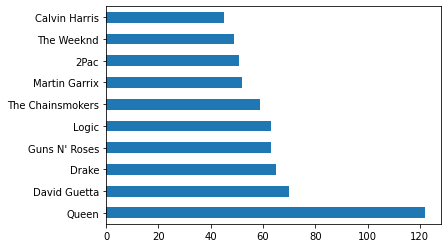

In [ ]:
data['track_artist'].value_counts().head(10).plot(kind='barh')

<AxesSubplot:>

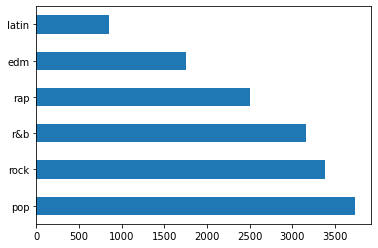

In [ ]:
data['playlist_genre'].value_counts().head(10).plot(kind='barh')

(array([2732.,  836.,  956., 1634., 2225., 2671., 2463., 1505.,  343.,
          40.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

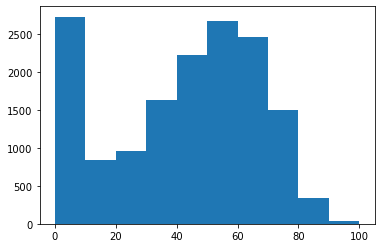

In [ ]:
plt.hist(data['track_popularity'])

In [ ]:
data['year'] = pd.to_datetime(data['track_album_release_date']).dt.year

(array([   9.,  113.,  382.,  524.,  592.,  805., 1273., 1484., 2235.,
        7988.]),
 array([1957. , 1963.3, 1969.6, 1975.9, 1982.2, 1988.5, 1994.8, 2001.1,
        2007.4, 2013.7, 2020. ]),
 <BarContainer object of 10 artists>)

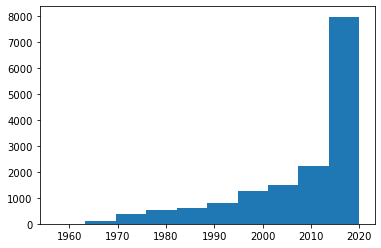

In [ ]:
plt.hist(data['year'])

In [ ]:
data['year'].value_counts().sort_values().head(10) #data imbalance

1958     1
1957     2
1960     3
1963     3
1964     7
1965     7
1966    13
1968    17
1967    29
1969    40
Name: year, dtype: int64

In [ ]:
np.max(data['year'])

2020

In [ ]:
np.min(data['year'])

1957

In [ ]:
## music in the dataset are mostly 2010-2020 songs. Below I will add Billboard hot 100 dataset into this s

In [ ]:
billboard = pd.read_csv('billboard_og.csv', index_col = 0)
billboard.drop([4, 1958, 2299, 2433], inplace =True) #remove the 4 lyrics that are not found
billboard.reset_index(drop = True, inplace = True)
billboard

In [ ]:
billboard.columns

Index(['lyrics', 'num_syllables', 'pos', 'year', 'fog_index', 'flesch_index',
       'num_words', 'num_lines', 'title', 'f_k_grade', 'artist',
       'difficult_words', 'num_dupes', 'neg', 'neu', 'compound', 'id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'uri', 'analysis_url',
       'artist_with_features', 'year_bin', 'image', 'cluster', 'Gender',
       'tag'],
      dtype='object')

In [ ]:
billboard = billboard[['lyrics', 'year', 'artist', 'title', 'tag','Gender']]

In [ ]:
data = data[['track_name', 'track_artist', 'lyrics', 'playlist_genre', 'year', 'track_popularity']]

In [ ]:
data.rename(columns={"track_name": "title", "track_artist": "artist", "playlist_genre": "tag", "track_popularity": "popularity"}, inplace = True)

In [ ]:
genres = np.unique(data.tag)
genres = [g for g in genres]
genres

['edm', 'latin', 'pop', 'r&b', 'rap', 'rock']

In [ ]:
import collections
import re

In [ ]:
def remove_quo(lst):
    return [re.sub(r"'", "", word).lstrip() for word in lst]

In [ ]:
billboard['tag'] = billboard.tag.apply(lambda x: x.strip('][').split(','))
billboard['tag'] = billboard.tag.apply(lambda x: remove_quo(x))                                                               

In [ ]:
tag_lst = [tag for song in billboard.tag for tag in song]
counter=collections.Counter(tag_lst)
counter.most_common(10)

[('pop', 1719),
 ('classic pop and rock', 1290),
 ('rock', 1063),
 ('american', 1035),
 ('pop rock', 903),
 ('dance-pop', 528),
 ('british', 474),
 ('hip hop rnb and dance hall', 450),
 ('pop and chart', 443),
 ('uk', 435)]

In [ ]:
billboard['tag_str'] = billboard['tag'].apply(lambda x: ' '.join(x))
billboard['tag_str']

0       american death by lung cancer easy listening s...
1                                         andrews sisters
2                                             country pop
3                        death by liver failure spiritual
4       adult contemporary american big band classic p...
                              ...                        
4019                          contemporary r&b electropop
4020    ballad contemporary r&b deep house hip hop pop...
4021             dance hip hop hip hop rnb and dance hall
4022    boy band dance-pop folk pop pop pop rock power...
4023    complextro contemporary r&b dance dance and el...
Name: tag_str, Length: 4024, dtype: object

In [ ]:
len(billboard['tag_str'].to_list())
lst = billboard['tag_str'].to_list()
len(re.findall('latin*', lst[0])) > 0

False

In [ ]:
dic = {'pop':[], 'edm': [], 'latin': [], 'r&b':[], 'rap':[], 'rock':[]}
for song in billboard['tag_str'].to_list():
    dic['pop'].append(len(re.findall('pop', song))> 0)
    dic['edm'].append(len(re.findall('elec*', song))>0)
    dic['latin'].append(len(re.findall('latin*', song)) >0)
    dic['r&b'].append(len(re.findall('r&b', song)) >0)
    dic['rap'].append(len(re.findall('hip|hop|rap', song)) >0)
    dic['rock'].append(len(re.findall('rock', song))>0)
    

In [ ]:
for g in genres:
    data[g] = data.tag.apply(lambda x: x == g)

In [ ]:
data = data.drop(columns = ['tag'])

In [ ]:
b = pd.DataFrame(dic)
f = [billboard, b]
new_billboard = pd.concat(f, axis = 1)
#new_billboard.to_csv('/Users/hzx/Desktop/UChicago/AU2021/MACS30124/project2/billboard_new.csv')

In [ ]:
new_billboard = pd.read_csv("billboard_new.csv")
new_billboard

,Unnamed: 0,lyrics,year,artist,title,tag,Gender,tag_str,pop,edm,latin,r&b,rap,rock
0,0,"Mona Lisa, Mona Lisa, men have named you\nYou'...",1950,Nat King Cole,Mona Lisa,"['american', 'death by lung cancer', 'easy lis...",male,american death by lung cancer easy listening s...,True,False,False,False,False,False
1,1,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,1950,Andrews Sisters,I Wanna Be Loved,['andrews sisters'],Group,andrews sisters,False,False,False,False,False,False
2,2,I was dancing with my darling to the Tennessee...,1950,Patti Page,Tennessee Waltz,"['country', 'pop']",female,country pop,True,False,False,False,False,False
3,3,Each time I hold someone new\nMy arms grow col...,1950,Tennessee Ernie Ford,I'll Never Be Free,"['death by liver failure', 'spiritual']",male,death by liver failure spiritual,False,False,False,False,False,False
4,4,"Hoop dee doo, hoop dee doo, \nI hear a polka ...",1950,Perry Como,Hoop-Dee-Doo,"['adult contemporary', 'american', 'big band',...",male,adult contemporary american big band classic p...,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,4019,(I guess right now you've got the last laugh)\...,2015,Alessia Cara,Here,"['contemporary r&b', 'electropop']",female,contemporary r&b electropop,True,True,False,True,False,False
4020,4020,My face above the water\nMy feet can't touch t...,2015,Mr. Probz,Waves,"['ballad', 'contemporary r&b', 'deep house', '...",male,ballad contemporary r&b deep house hip hop pop...,True,False,False,True,True,False
4021,4021,You know from the moment she turned around\nSh...,2015,Ne-Yo,She Knows,"['dance', 'hip hop', 'hip hop rnb and dance ha...",male,dance hip hop hip hop rnb and dance hall,False,False,False,False,True,False
4022,4022,Going out tonight\nChanges into something red\...,2015,One Direction,Night Changes,"['boy band', 'dance-pop', 'folk pop', 'pop', '...",Group,boy band dance-pop folk pop pop pop rock power...,True,False,False,False,False,True


In [ ]:
data['Gender'] = "Unknown"

In [ ]:
new_billboard = pd.read_csv("billboard_new.csv", index_col = 0)
new_billboard = new_billboard.drop(columns = ['tag', 'tag_str'])
new_billboard.columns

Index(['lyrics', 'year', 'artist', 'title', 'Gender', 'pop', 'edm', 'latin',
       'r&b', 'rap', 'rock'],
      dtype='object')

In [ ]:
combined = pd.concat([data, new_billboard])
combined

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender
1,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",2017,28.0,False,False,False,False,False,True,Unknown
2,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",2005,0.0,False,False,False,True,False,False,Unknown
3,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,2012,41.0,False,False,False,True,False,False,Unknown
4,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,2019,65.0,False,False,True,False,False,False,Unknown
5,Soldier,James TW,"Hold your breath, don't look down, keep trying...",2019,70.0,False,False,False,True,False,False,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
4019,Here,Alessia Cara,(I guess right now you've got the last laugh)\...,2015,NaN,True,False,True,True,False,False,female
4020,Waves,Mr. Probz,My face above the water\nMy feet can't touch t...,2015,NaN,False,False,True,True,True,False,male
4021,She Knows,Ne-Yo,You know from the moment she turned around\nSh...,2015,NaN,False,False,False,False,True,False,male
4022,Night Changes,One Direction,Going out tonight\nChanges into something red\...,2015,NaN,False,False,True,False,False,True,Group


In [ ]:
subset = combined.columns.to_list()
subset.remove('popularity')
subset

['title',
 'artist',
 'lyrics',
 'year',
 'edm',
 'latin',
 'pop',
 'r&b',
 'rap',
 'rock',
 'Gender']

In [ ]:
cleaned = combined.drop_duplicates(subset =subset)
print(len(combined) - len(cleaned), "duplicates")

495 duplicates


In [ ]:
#convert year to year_bin
import ppmi
cleaned['year_bin'] = cleaned['year'].apply(lambda x: ppmi.convert_year(x))
cleaned.reset_index(drop = True).to_csv("sp_bb_cleaned.csv", index = False)

##MetroLyric Dataset

https://github.com/hiteshyalamanchili/SongGenreClassification

In [ ]:
data = pd.read_csv("english_cleaned_lyrics.csv", index_col = 0).drop(columns = ['index'])

In [ ]:
data.rename(columns={"song": "title"}, inplace = True)
data.dropna(subset = ['lyrics', 'title', 'artist'], inplace = True)
data = data.reset_index(drop = True)

In [ ]:
data.loc[data.title == 'who-am-i-drinking-tonight'].lyrics.values

array(["I gotta say Boy after only just a couple of dates You're hands down outright blowing my mind In nearly every single way You're amazing and yet There's only so much I can get From picnics long walks flowers and talks Baby here's what I suggest It's time I see ya belly up to a bar How bout ya show me what kind of cowboy you are Are you a Kenny tequila Buffet margarita Or an Alan Jackson hurricane Are you a good time flask of moonshine Going George Strait to my brain A girl can tell a lot about a boy in one shot I gotta know you've got a Bocephus side So what's in the cup order it up Who am I drinking tonight You might not have guessed Judging by my heels and lacy dress I'm a wide neck Gretchen Loretta Lynn I've learned from the best Women like that know how to throw a few back We gotta have a man who can keep up with all that Are you a Kenny tequila Buffet margarita Or an Alan Jackson hurricane Are you a good time flask of moonshine Going George Strait to my brain A girl can tell

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218210 entries, 0 to 362236
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   song    218209 non-null  object
 1   year    218210 non-null  int64 
 2   artist  218210 non-null  object
 3   genre   218210 non-null  object
 4   lyrics  218210 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.0+ MB


In [ ]:
np.max(data.year)

2016

In [ ]:
np.min(data.year)

67

In [ ]:
data['year_bin'] = data.year.apply(lambda x: ppmi.convert_year(x))

In [ ]:
data['year_bin'].value_counts()

2000s    150449
2010s     58088
1990s      6273
1980s      1741
1970s      1651
1960s         1
Name: year_bin, dtype: int64

Format title and artists to be consistent with the other dataset

In [ ]:
stri = "cashew"
re.sub("-", " ", stri)

'cashew'

In [ ]:
def remove_dash(x):
  try:
    re.sub("-", " ", x)
    return re.sub("-", " ", x)
  except:
    return x

In [ ]:
len(data)

218209

In [ ]:
data['title_lower'] = data['title'].apply(lambda x: remove_dash(x))
data['title_lower']

0                           ego remix
1                        then tell me
2                             honesty
3                     you are my rock
4                       black culture
                     ...             
218204      who am i drinking tonight
218205                           liar
218206                    last supper
218207    christ alone live in studio
218208                           amen
Name: title_lower, Length: 218209, dtype: object

In [ ]:
data['title'] = data['title_lower'].apply(lambda x: x.title())

In [ ]:
data['artist_lower'] = data['artist'].apply(lambda x: remove_dash(x))
data['artist'] = data['artist_lower'].apply(lambda x: x.title())

In [ ]:
data['genre'] = data['genre'].apply(lambda x: x.lower())
data['genre'].value_counts()

rock          100053
pop            34137
hip-hop        22654
metal          21210
country        14158
jazz            7309
electronic      6942
other           3786
r&b             3336
indie           2935
folk            1689
Name: genre, dtype: int64

In [ ]:
dic = {'pop':[], 'edm': [], 'latin': [], 'r&b':[], 'rap':[], 'rock':[]}
for song in data['genre'].to_list():
    dic['pop'].append(len(re.findall('pop', song))> 0)
    dic['edm'].append(len(re.findall('elec*', song))>0)
    dic['latin'].append(len(re.findall('latin*', song)) >0)
    dic['r&b'].append(len(re.findall('r&b', song)) >0)
    dic['rap'].append(len(re.findall('hip|hop|rap', song)) >0)
    dic['rock'].append(len(re.findall('rock', song))>0)

In [ ]:
b = pd.DataFrame(dic)
f = [data, b]
new_metro = pd.concat(f, axis = 1)

In [ ]:
new_metro = new_metro.drop(columns = ['title_lower', 'genre'])
new_metro = new_metro[new_metro.year > 1969]
new_metro.year_bin.value_counts()

2000s    150449
2010s     58088
1990s      6273
1980s      1741
1970s      1651
Name: year_bin, dtype: int64

In [ ]:
new_metro.columns

Index(['title', 'year', 'artist', 'lyrics', 'year_bin', 'artist_lower', 'pop',
       'edm', 'latin', 'r&b', 'rap', 'rock'],
      dtype='object')

In [ ]:
new_metro['Gender'] = "Unknown"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Record linkage with Spotify and Billboard Datasets

In [ ]:
cleaned = pd.read_csv("sp_bb_cleaned.csv")
cleaned['artist_lower'] = cleaned['artist'].apply(lambda x: x.lower())

In [ ]:
frames = [cleaned, new_metro]

result = pd.concat(frames, ignore_index=True)


In [ ]:
result.columns

Index(['title', 'artist', 'lyrics', 'year', 'popularity', 'edm', 'latin',
       'pop', 'r&b', 'rap', 'rock', 'Gender', 'year_bin', 'artist_lower'],
      dtype='object')

In [ ]:
result

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower
0,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",2017,28.0,False,False,False,False,False,True,Unknown,2010s,steady rollin
1,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",2005,0.0,False,False,False,True,False,False,Unknown,2000s,bell biv devoe
2,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,2012,41.0,False,False,False,True,False,False,Unknown,2010s,ceelo green
3,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,2019,65.0,False,False,True,False,False,False,Unknown,2010s,kard
4,Soldier,James TW,"Hold your breath, don't look down, keep trying...",2019,70.0,False,False,False,True,False,False,Unknown,2010s,james tw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237131,Who Am I Drinking Tonight,Edens Edge,I gotta say Boy after only just a couple of da...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge
237132,Liar,Edens Edge,I helped you find her diamond ring You made me...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge
237133,Last Supper,Edens Edge,Look at the couple in the corner booth Looks a...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge
237134,Christ Alone Live In Studio,Edens Edge,When I fly off this mortal earth And I'm measu...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge


In [ ]:
result[result.duplicated(subset = ['title', 'artist'], keep = False)].sort_values(['title', 'artist_lower'])

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower
6935,...Baby One More Time,Britney Spears,"Oh baby, baby Oh baby, baby Oh baby, baby, how...",1999,75.0,False,False,True,False,False,False,Unknown,1990s,britney spears
17652,...Baby One More Time,Britney Spears,"Oh, baby, baby\nOh, baby, baby\n\nOh, baby, ba...",1999,NaN,True,False,True,False,False,False,female,1990s,britney spears
6498,1 Adam 12,Delinquent Habits,I'm predisposed for abuse I can take it so bri...,1998,28.0,False,True,False,False,False,False,Unknown,1990s,delinquent habits
61741,1 Adam 12,Delinquent Habits,I'm predisposed for abuse I can take it so br...,2006,NaN,False,False,False,False,True,False,Unknown,2000s,delinquent habits
3132,1 Thing,Amerie,"Na, na, na, na, na, oh Na, na, na, na, na, oh ...",2005,59.0,False,False,False,True,False,False,Unknown,2000s,amerie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14441,shut up,Greyson Chance,"I cannot hold my tongue, you give me much to s...",2019,58.0,False,False,True,False,False,False,Unknown,2010s,greyson chance
5219,sobeautiful,Musiq Soulchild,"You're my baby, my lover, my lady All night yo...",2008,58.0,False,False,False,True,False,False,Unknown,2000s,musiq soulchild
6465,sobeautiful,Musiq Soulchild,"You're my baby, my lover, my lady All night yo...",2011,36.0,False,False,False,True,False,False,Unknown,2010s,musiq soulchild
5349,"thank u, next",Ariana Grande,Thought I'd end up with Sean But he wasn't a m...,2018,28.0,False,False,True,False,False,False,Unknown,2010s,ariana grande


In [ ]:
result.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)

In [ ]:
result

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower
0,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",2017,28.0,False,False,False,False,False,True,Unknown,2010s,steady rollin
1,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",2005,0.0,False,False,False,True,False,False,Unknown,2000s,bell biv devoe
2,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,2012,41.0,False,False,False,True,False,False,Unknown,2010s,ceelo green
3,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,2019,65.0,False,False,True,False,False,False,Unknown,2010s,kard
4,Soldier,James TW,"Hold your breath, don't look down, keep trying...",2019,70.0,False,False,False,True,False,False,Unknown,2010s,james tw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237131,Who Am I Drinking Tonight,Edens Edge,I gotta say Boy after only just a couple of da...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge
237132,Liar,Edens Edge,I helped you find her diamond ring You made me...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge
237133,Last Supper,Edens Edge,Look at the couple in the corner booth Looks a...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge
237134,Christ Alone Live In Studio,Edens Edge,When I fly off this mortal earth And I'm measu...,2012,NaN,False,False,False,False,False,False,Unknown,2010s,edens edge


# Record Linkage for Gender

In [ ]:
result[(result.year>1969) & (result.year<2020)].year_bin.value_counts()

2000s    153608
2010s     67727
1990s      8443
1980s      3337
1970s      2970
Name: year_bin, dtype: int64

In [ ]:
cleaned = result[(result.year>1969) & (result.year<2020)]

In [ ]:
gender = pd.read_csv("Gender_Dataset_1.3.csv")

In [ ]:
gender = gender.dropna(subset = ['name'])

In [ ]:
gender.gender.fillna(gender.is_band, inplace = True)
gender = gender[gender.gender != False]

In [ ]:
gender.gender.value_counts()

True                     188053
male                       3725
female                      898
mixed                       324
non-binary                  200
transgender                  83
androgynous                  61
transgender woman            49
transgender man              23
genderfluid                  19
genderqueer                  17
gender non-conforming        12
gender neutral               10
agender                       8
two-spirit                    5
trans-masculine               4
trans-feminine                3
other gender identity         1
Name: gender, dtype: int64

In [ ]:
len(gender)

193504

In [ ]:
gender = gender.drop_duplicates(subset = ['name'],ignore_index = True)
len(gender)

186070

In [ ]:
def convert_gender(gender):
    if gender == True or gender == "mixed":
        return "Group"
    else:
        return gender

In [ ]:
gender['gender_'] = gender.gender.apply(lambda x: convert_gender(x))

In [ ]:
gender.gender_.value_counts()

Group                    181013
male                       3680
female                      882
non-binary                  196
transgender                  83
androgynous                  59
transgender woman            48
transgender man              21
genderfluid                  19
genderqueer                  17
gender non-conforming        12
gender neutral               10
agender                       8
two-spirit                    5
trans-masculine               4
trans-feminine                3
other gender identity         1
Name: gender_, dtype: int64

In [ ]:
gender['name'] = clean(gender['name'])

/usr/local/lib/python3.7/dist-packages/recordlinkage/preprocessing/cleaning.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'(\[.*?\]|\(.*?\)|\{.*?\})', '')
/usr/local/lib/python3.7/dist-packages/recordlinkage/preprocessing/cleaning.py:118: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_none, '')
/usr/local/lib/python3.7/dist-packages/recordlinkage/preprocessing/cleaning.py:121: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_whitespace, ' ')
/usr/local/lib/python3.7/dist-packages/recordlinkage/preprocessing/cleaning.py:124: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'\s\s+', ' ')


In [ ]:
cleaned['artist_lower'] = clean(cleaned['artist'])

/usr/local/lib/python3.7/dist-packages/recordlinkage/preprocessing/cleaning.py:114: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'(\[.*?\]|\(.*?\)|\{.*?\})', '')
/usr/local/lib/python3.7/dist-packages/recordlinkage/preprocessing/cleaning.py:118: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_none, '')
/usr/local/lib/python3.7/dist-packages/recordlinkage/preprocessing/cleaning.py:121: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(replace_by_whitespace, ' ')
/usr/local/lib/python3.7/dist-packages/recordlinkage/preprocessing/cleaning.py:124: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace(r'\s\s+', ' ')
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to 

In [ ]:
cleaned = cleaned.reset_index(drop = True)

In [ ]:
gender = gender[['name', 'gender_']].reset_index(drop = True)

In [ ]:
clean_unknown = cleaned.loc[cleaned.Gender == 'Unknown']

In [ ]:
# create an indexing object 
indexer_block = recordlinkage.BlockIndex(left_on = "artist_lower", right_on = "name")

# create a pandas MultiIndex with candidate links
candidate_links = indexer_block.index(cleaned, gender)

In [ ]:
comparison = recordlinkage.Compare()
comparison.string("artist_lower", "name", method = "jarowinkler", label = "jw_name")
feature = comparison.compute(candidate_links, cleaned, gender)

In [ ]:
feature

,,jw_name
0,73564,1.0
1,593,1.0
190,593,1.0
502,593,1.0
1384,593,1.0
...,...,...
236045,17553,1.0
236046,17553,1.0
236047,17553,1.0
236048,17553,1.0


In [ ]:
#feature = feature.reset_index()
confirm_f = feature.reset_index()

In [ ]:
confirm_f = confirm_f.loc[confirm_f['jw_name'] >0.8]

In [ ]:
c = feature.reset_index()
np.unique(c.loc[c['jw_name'] <0.8].level_0)

array([  255,  3802, 11731])

In [ ]:
cleaned.iloc[np.unique(c.loc[c['jw_name'] <0.8].level_0)] #these three artists does not exist in the gender dataset due to the format of their names
#cleaned.iloc[255].artist

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched
255,Lebensborn - Update,[:SITD:],His hair was blond His eyes were blue He toed ...,2011,4.0,False,False,True,False,False,False,Unknown,2010s,,Unknown
3802,Cinnamon Girl - Radio Edit,[dunkelbunt],I met her on the milky way Who she was I could...,2009,47.0,True,False,False,False,False,False,Unknown,2000s,,Unknown
11731,Silver Bombs,[:SITD:],Silver bombs towards the sky Face to face - ey...,2007,5.0,False,False,True,False,False,False,Unknown,2000s,,Unknown


In [ ]:
cleaned.loc[confirm_f['level_0'], 'Gender'] 

0         Unknown
1         Unknown
190       Unknown
502       Unknown
1384      Unknown
           ...   
236045    Unknown
236046    Unknown
236047    Unknown
236048    Unknown
236049    Unknown
Name: Gender, Length: 127463, dtype: object

In [ ]:
#cleaned['gender_matched'] = "Unknown"
cleaned.loc[confirm_f['level_0'], 'gender_matched']  = gender.loc[confirm_f['level_1'], 'gender_'].to_list()

In [ ]:
cleaned.Gender.value_counts()

Unknown    232800
male         1252
Group        1247
female        786
Name: Gender, dtype: int64

In [ ]:
cleaned.gender_matched.value_counts()

Group                    87065
male                     28362
female                    7749
non-binary                 317
androgynous                 76
agender                     36
genderfluid                 32
genderqueer                 12
transgender woman           12
transgender                  6
gender non-conforming        1
Name: gender_matched, dtype: int64

In [ ]:
cleaned[cleaned.gender_matched == "Unknown"].groupby("artist").count()

,title,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched
artist,,,,,,,,,,,,,,
!deladap,1,1,1,1,1,1,1,1,1,1,1,1,1,1
'Til Tuesday,1,1,1,1,1,1,1,1,1,1,1,1,1,1
(Sandy) Alex G,1,1,1,1,1,1,1,1,1,1,1,1,1,1
009 Sound System,4,4,4,0,4,4,4,4,4,4,4,4,4,4
03 Greedo,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
st. august,1,1,1,1,1,1,1,1,1,1,1,1,1,1
tobi lou,1,1,1,1,1,1,1,1,1,1,1,1,1,1
twuan,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
cleaned.loc[cleaned.gender_matched.isna(), "gender_matched"] = cleaned.loc[cleaned.gender_matched.isna(), "Gender"]
#For those unknown from the gender dataset (NaN), impute with known gender class

In [ ]:
cleaned.gender_matched.value_counts()

Unknown                  111201
Group                     87401
male                      28900
female                     8091
non-binary                  317
androgynous                  76
agender                      36
genderfluid                  32
genderqueer                  12
transgender woman            12
transgender                   6
gender non-conforming         1
Name: gender_matched, dtype: int64

In [ ]:
is_str = cleaned.gender_matched.apply(lambda x: isinstance(x, str))
cleaned[~is_str]

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched


In [ ]:
cleaned['gender_matched'] = cleaned['gender_matched'].apply(lambda x: x.lower())
cleaned['gender_matched'].value_counts()

unknown                  111201
group                     87401
male                      28900
female                     8091
non-binary                  317
androgynous                  76
agender                      36
genderfluid                  32
genderqueer                  12
transgender woman            12
transgender                   6
gender non-conforming         1
Name: gender_matched, dtype: int64

In [ ]:
cleaned.to_csv("sp_bb_metro_matched.csv", index = False)

#Exploratory

In [ ]:
GENDER_SLURS = ["bitch", "slut",  "sissy", "whore", "ho", "hoe", "skeezer", "shawty", "shorty"]

In [ ]:
cleaned = pd.read_csv("sp_bb_metro_matched.csv")

In [ ]:
cleaned['gender_matched'].value_counts()

unknown                  111201
group                     87401
male                      28900
female                     8091
non-binary                  317
androgynous                  76
agender                      36
genderfluid                  32
genderqueer                  12
transgender woman            12
transgender                   6
gender non-conforming         1
Name: gender_matched, dtype: int64

In [ ]:
print("Num of edm songs:", sum(cleaned.edm))
print("Num of latin songs:", sum(cleaned.latin))
print("Num of pop songs:", sum(cleaned['pop']))
print("Num of r&b songs:", sum(cleaned['r&b']))
print("Num of rap songs:", sum(cleaned.rap))
print("Num of rock songs:", sum(cleaned.rock))

Num of edm songs: 9076
Num of latin songs: 869
Num of pop songs: 40116
Num of r&b songs: 6851
Num of rap songs: 25836
Num of rock songs: 104946


In [ ]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236085 entries, 0 to 236084
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           236085 non-null  object 
 1   artist          236085 non-null  object 
 2   lyrics          236085 non-null  object 
 3   year            236085 non-null  int64  
 4   popularity      14598 non-null   float64
 5   edm             236085 non-null  bool   
 6   latin           236085 non-null  bool   
 7   pop             236085 non-null  bool   
 8   r&b             236085 non-null  bool   
 9   rap             236085 non-null  bool   
 10  rock            236085 non-null  bool   
 11  Gender          236085 non-null  object 
 12  year_bin        236085 non-null  object 
 13  artist_lower    236082 non-null  object 
 14  gender_matched  236085 non-null  object 
dtypes: bool(6), float64(1), int64(1), object(7)
memory usage: 17.6+ MB


In [ ]:
cleaned.Gender.value_counts()

Unknown    232800
male         1252
Group        1247
female        786
Name: Gender, dtype: int64

In [ ]:
cleaned.gender_matched.value_counts()

unknown                  111201
group                     87401
male                      28900
female                     8091
non-binary                  317
androgynous                  76
agender                      36
genderfluid                  32
genderqueer                  12
transgender woman            12
transgender                   6
gender non-conforming         1
Name: gender_matched, dtype: int64

## Counts of gendered slurs

In [ ]:
import spacy
import nltk
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [ ]:
nlp = spacy.load("en")

def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [ ]:
cleaned.year_bin.value_counts()

2000s    153608
2010s     67727
1990s      8443
1980s      3337
1970s      2970
Name: year_bin, dtype: int64

In [ ]:
cleaned['tokenized'] = cleaned.lyrics.apply(lambda x: normalizeTokens(x))

In [ ]:
cleaned.to_csv("sp_bb_metro_matched_tokenized.csv")

In [ ]:
#cleaned = pd.read_csv("sp_bb_metro_matched_tokenized.csv", index_col = 0)
#cleaned['tokenized'] = [literal_eval(x) for x in cleaned.tokenized.to_list()]

In [ ]:
with open('bad-words.txt', 'r') as fp:
    bad_wrds = fp.read().split('\n')

In [ ]:
GENDER_SLURS = ['bitch', 'slut', 'sissy', 'whore', 'ho', 'hoe', 'skeezer', 'shawty', 'shorty']

In [ ]:
slurs_lst = []
for word in GENDER_SLURS:
    slurs_lst.extend([w for w in bad_wrds if word in w])

slurs_lst.append("hoe")
slurs_lst.append("shorty")
slurs_lst.append("shawty")
#skeezer_lst = ["skeezer"]

In [ ]:
textfile = open("slurs.txt", "w")
for element in slurs_lst:
    textfile.write(element + ", ")
textfile. close()

In [ ]:
bitch_lst = [w for w in bad_wrds if "bitch" in w]

In [ ]:
def count_slurs(tokens, lst):
  found = 0
  for t in tokens:
      if t in lst:
          found +=1
  return found

In [ ]:
cleaned['count_slurs'] = cleaned.tokenized.apply(lambda x: count_slurs(x, slurs_lst))

In [ ]:
cleaned['length'] = cleaned.tokenized.apply(lambda x: len(x))

In [ ]:
slurs_freq = cleaned.groupby(["year_bin"])[['length', 'count_slurs']].sum().reset_index()

In [ ]:
slurs_freq['percentage'] = slurs_freq['count_slurs'] / slurs_freq['length'] * 100
slurs_freq

,year_bin,length,count_slurs,percentage
0,1970s,295910,631,0.213241
1,1980s,357111,617,0.172775
2,1990s,1008959,4714,0.467214
3,2000s,15026179,59537,0.396222
4,2010s,8224958,49776,0.605182


In [ ]:
!pip install transformers
import transformers
import preprocessing

In [ ]:
gendered = cleaned.loc[(cleaned.gender_matched != 'unknown') & (cleaned.gender_matched != 'group')]
gendered['gender_matched'] = gendered.gender_matched.apply(lambda x: preprocessing.convert_gender(x))
gendered.gender_matched.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


male          28900
female         8091
non-binary      492
Name: gender_matched, dtype: int64

In [ ]:
gender_freq = gendered.groupby(['year_bin', 'gender_matched'])[['length', 'count_slurs']].sum().reset_index()
gender_freq['percentage'] = gender_freq['count_slurs'] / gender_freq['length'] *100
gender_freq

,year_bin,gender_matched,length,count_slurs,percentage
0,1970s,female,15068,3,0.019910
1,1970s,male,118509,342,0.288586
2,1980s,female,28481,18,0.063200
3,1980s,male,113969,166,0.145654
4,1990s,female,48039,66,0.137388
5,1990s,male,240072,1186,0.494018
6,1990s,non-binary,74,0,0.000000
7,2000s,female,422967,574,0.135708
8,2000s,male,1847640,11421,0.618140
9,2000s,non-binary,18011,9,0.049969


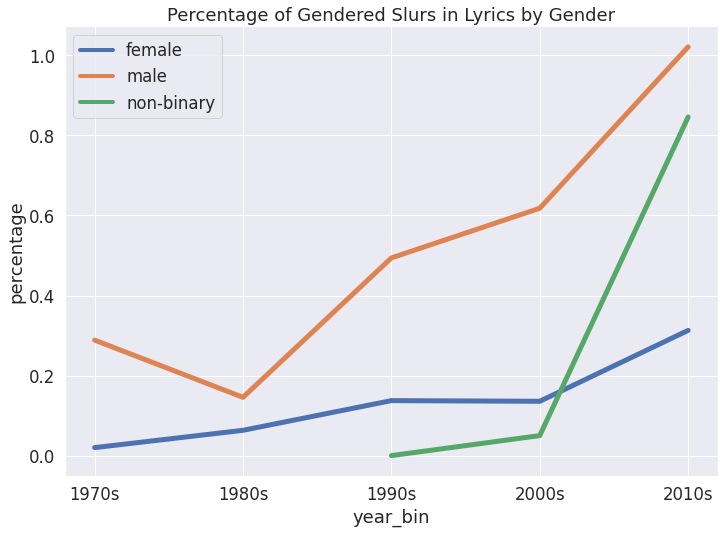

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots()

sns.lineplot(x="year_bin", y = "percentage", hue = 'gender_matched', data = gender_freq, linewidth = 5,\
             color= "tab10").set_title("Percentage of Gendered Slurs in Lyrics by Gender")
leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(4.0)


plt.savefig("plot/perc_slurs_gender.png")
plt.show()

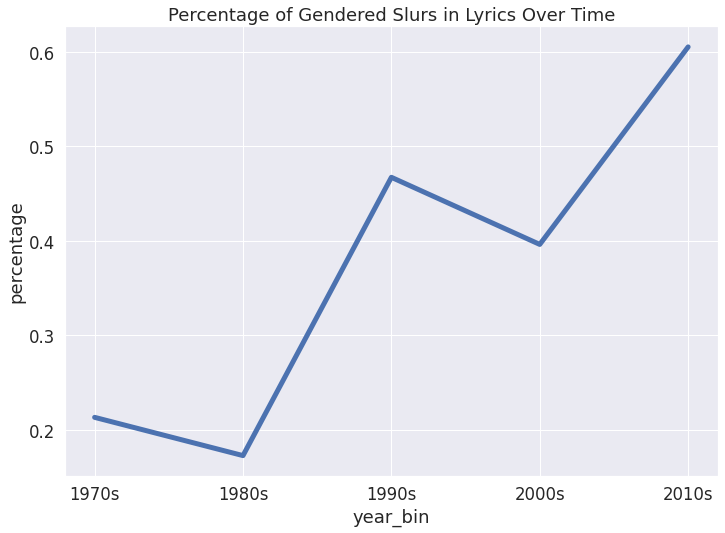

In [ ]:
from seaborn.palettes import color_palette
sns.set(font_scale=1.5)
fig, ax = plt.subplots()

sns.lineplot(x="year_bin", y = "percentage",data = slurs_freq, linewidth = 5).set_title("Percentage of Gendered Slurs in Lyrics Over Time")

for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.savefig("plot/perc_slurs.png")
plt.show()

In [ ]:
year_samp = cleaned.groupby("year_bin").sample(500, random_state=2970)
year_samp

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,tokenized,count_slurs,length
14791,Love Train,O'Jays,People all over the world (everybody)\nJoin ha...,1973,NaN,False,False,True,True,False,True,Group,1970s,ojays,group,"[people, world, everybody, join, hand, join, s...",0,165
2118,Leaving Home Ain't Easy - Remastered 2011,Queen,I take a step outside and I breathe the air An...,1978,37.0,False,False,False,False,False,True,Unknown,1970s,queen,male,"[step, outside, breathe, air, slam, door, way,...",0,83
14782,Half Breed,Cher,My father married a pure Cherokee\nMy mother's...,1973,NaN,False,False,True,False,False,True,female,1970s,cher,female,"[father, marry, pure, cherokee, mother, people...",0,97
151,Rhiannon,Fleetwood Mac,Rhiannon rings like a bell through the night A...,1975,68.0,False,False,False,False,False,True,Unknown,1970s,fleetwood mac,group,"[rhiannon, ring, like, bell, night, love, love...",0,105
137407,Please Don T Turn Out The Lights,Bee Gees,Every time I need reality in jeopardy of losin...,1972,NaN,False,False,True,False,False,False,Unknown,1970s,bee gees,male,"[time, need, reality, jeopardy, lose, strong, ...",0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68074,Do Something,Dipset,Niggas mad cause every other month man I pop i...,2015,NaN,False,False,False,False,True,False,Unknown,2010s,dipset,group,"[niggas, mad, cause, month, man, pop, new, som...",1,39
171820,Lend Myself To The Night,Devildriver,These spirits exact a heavy toll I've had it T...,2011,NaN,False,False,False,False,False,False,Unknown,2010s,devildriver,group,"[spirit, exact, heavy, toll, throw, caution, w...",0,62
218515,Rayon Drive,Game Theory,Fair Oaks hot spot between Howe and Watt Sell ...,2015,NaN,False,False,True,False,False,False,Unknown,2010s,game theory,group,"[fair, oak, hot, spot, howe, watt, sell, get, ...",0,65
118845,Crazy Rhythm,Chico Hamilton,Crazy rhythm here's the doorway I'll go my way...,2015,NaN,False,False,False,False,False,False,Unknown,2010s,chico hamilton,unknown,"[crazy, rhythm, doorway, way, way, crazy, rhyt...",0,65


In [ ]:
def count_freq_(x, lst):
    cnt = 0
    for w in lst:
        if w in x:
            cnt +=1
    return cnt

In [ ]:
whore_lst = [w for w in bad_wrds if "whore" in w]
fuck_lst = [w for w in bad_wrds if "fuck" in w]
shit_lst = [w for w in bad_wrds if "shit" in w]
sissy_lst = [w for w in bad_wrds if "sissy" in w]
slut_lst = [w for w in bad_wrds if "slut" in w]
hoe_lst = [w for w in bad_wrds if "hoe" in w]
hoe_lst.append("hoe")
bitch_lst = [w for w in bad_wrds if "bitch" in w]
shorty_lst = [w for w in bad_wrds if "shorty" in w or "shawty" in w]
shorty_lst.append("shorty")
shorty_lst.append("shawty")

In [ ]:
GENDER_SLURS_ = ['bitch', 'slut', 'sissy', 'whore', 'hoe', 'shorty']
lsts = [bitch_lst, slut_lst, sissy_lst, whore_lst, hoe_lst, shorty_lst]

In [ ]:
for i, w in enumerate(GENDER_SLURS_):
  cleaned[w] = cleaned.tokenized.apply(lambda x: count_freq_(x, lsts[i]))

In [ ]:
for i, w in enumerate(GENDER_SLURS_):
  gendered[w] = gendered.tokenized.apply(lambda x: count_freq_(x, lsts[i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
female = cleaned.loc[cleaned.gender_matched == 'female'].groupby('year_bin').sum()[['length', 'bitch', 'slut', 'sissy', 'whore', 'hoe', 'shorty']].reset_index()
female

,year_bin,length,bitch,slut,sissy,whore,hoe,shorty
0,1970s,15068,0,0,0,0,0,0
1,1980s,28481,0,0,0,0,0,0
2,1990s,48039,4,0,0,1,2,1
3,2000s,422967,51,9,0,10,8,29
4,2010s,456703,157,0,0,1,29,30


In [ ]:
for q in GENDER_SLURS_:
    female[q] = female[q]/female.length * 100

In [ ]:
female

,year_bin,length,bitch,slut,sissy,whore,hoe,shorty
0,1970s,15068,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,1980s,28481,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,1990s,48039,0.008327,0.000000,0.0,0.002082,0.004163,0.002082
3,2000s,422967,0.012058,0.002128,0.0,0.002364,0.001891,0.006856
4,2010s,456703,0.034377,0.000000,0.0,0.000219,0.006350,0.006569


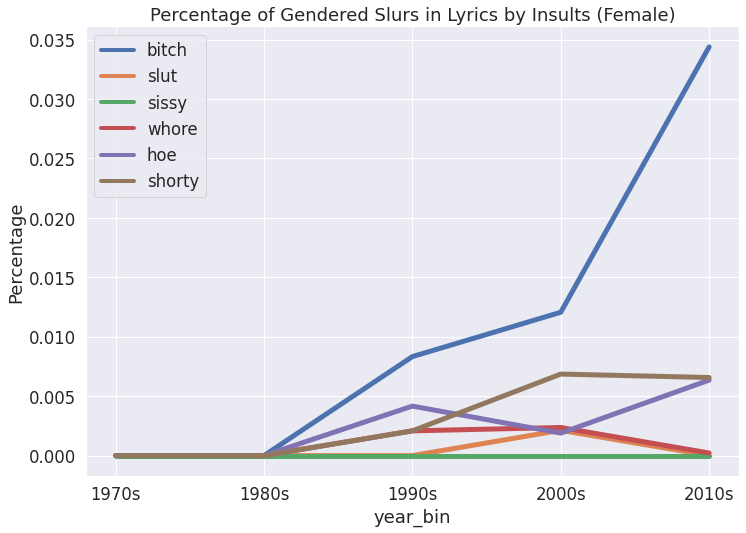

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots()

sns.lineplot(x="year_bin", y = "value",hue = 'variable', data = pd.melt(female.drop(columns = 'length'), 'year_bin'), linewidth = 5,\
             color= "tab10").set_title("Percentage of Gendered Slurs in Lyrics by Insults (Female)")
leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.ylabel("Percentage")
plt.savefig("plot/perc_insult_female.png")
plt.show()

In [ ]:
cleaned.columns

Index(['title', 'artist', 'lyrics', 'year', 'popularity', 'edm', 'latin',
       'pop', 'r&b', 'rap', 'rock', 'Gender', 'year_bin', 'artist_lower',
       'gender_matched', 'tokenized', 'count_slurs', 'length', 'bitch', 'slut',
       'sissy', 'whore', 'hoe', 'shorty'],
      dtype='object')

In [ ]:
female = cleaned.loc[cleaned.gender_matched == 'female'].groupby('year_bin').sum()[['bitch', 'slut', 'sissy', 'whore', 'hoe', 'shorty']].reset_index()
female

,year_bin,bitch,slut,sissy,whore,hoe,shorty
0,1970s,0,0,0,0,0,0
1,1980s,0,0,0,0,0,0
2,1990s,4,0,0,1,2,1
3,2000s,51,9,0,10,8,29
4,2010s,157,0,0,1,29,30


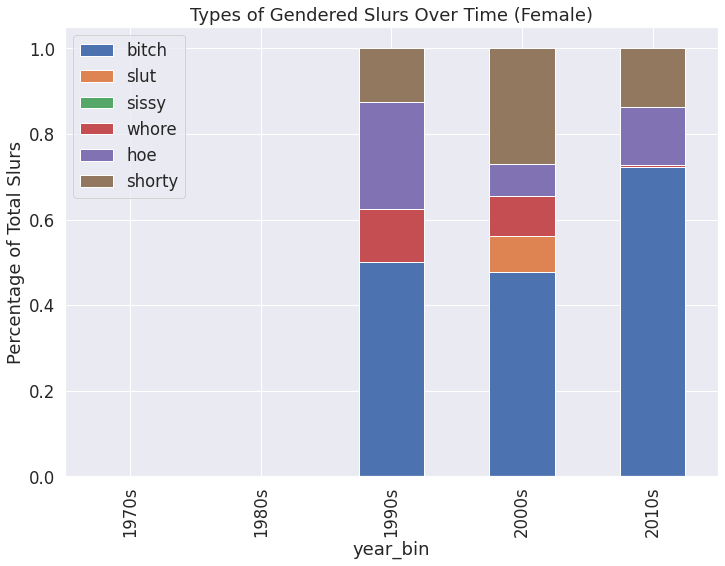

In [ ]:
female = cleaned.loc[cleaned.gender_matched == 'female'].groupby('year_bin').sum()[['bitch', 'slut', 'sissy', 'whore', 'hoe', 'shorty']].reset_index()
female['total']= female.bitch + female.slut + female.sissy + female.whore + female.hoe + female.shorty
for q in GENDER_SLURS_:
    female[q] = female[q]/female.total 
female = female.drop(columns = ["total"])
sns.set(font_scale=1.5)
female.set_index('year_bin').plot(kind = "bar", stacked = True)
plt.ylabel("Percentage of Total Slurs")
plt.title("Types of Gendered Slurs Over Time (Female)")
plt.savefig("plot/insult_female_perc.png")
plt.show()

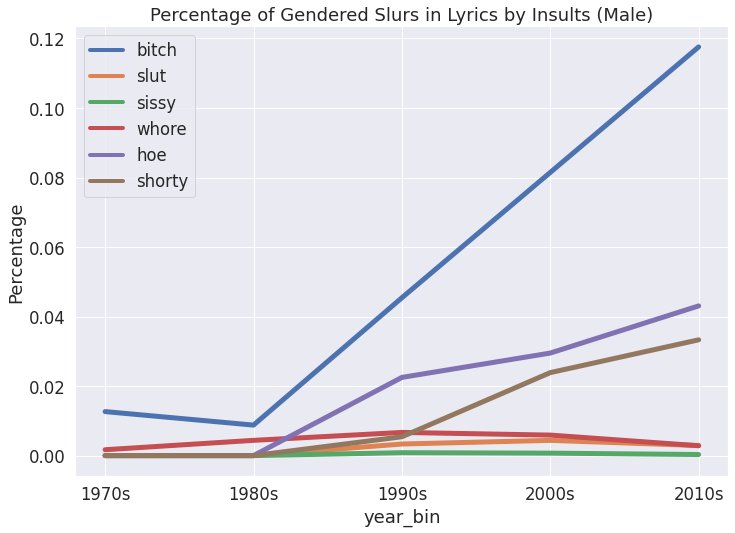

In [ ]:
male = cleaned.loc[cleaned.gender_matched == 'male'].groupby('year_bin').sum()[['length', 'bitch', 'slut', 'sissy', 'whore', 'hoe', 'shorty']].reset_index()
for q in GENDER_SLURS_:
    male[q] = male[q]/male.length * 100

sns.set(font_scale=1.5)
fig, ax = plt.subplots()
sns.lineplot(x="year_bin", y = "value",hue = 'variable', data = pd.melt(male.drop(columns = 'length'), 'year_bin'), linewidth = 5,\
             color= "tab10").set_title("Percentage of Gendered Slurs in Lyrics by Insults (Male)")
leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.ylabel("Percentage")
plt.savefig("plot/perc_insult_male.png")
plt.show()

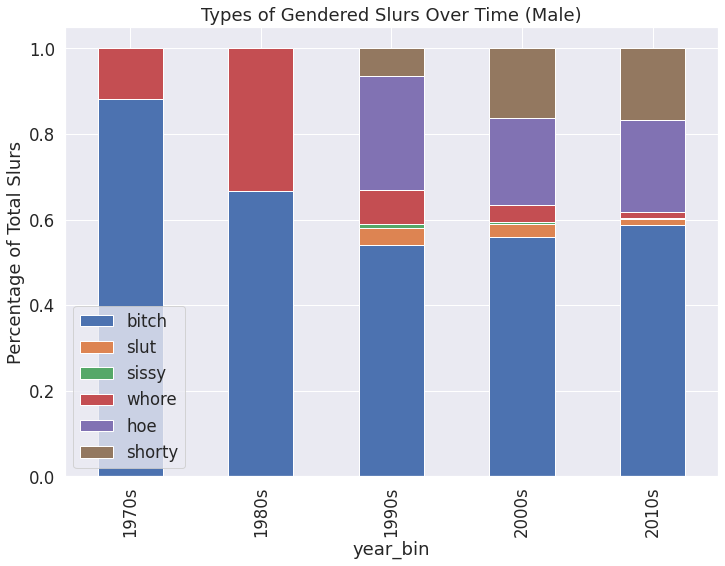

In [ ]:
male = cleaned.loc[cleaned.gender_matched == 'male'].groupby('year_bin').sum()[['bitch', 'slut', 'sissy', 'whore', 'hoe', 'shorty']].reset_index()
male['total']= male.bitch + male.slut + male.sissy + male.whore + male.hoe + male.shorty
for q in GENDER_SLURS_:
    male[q] = male[q]/male.total 
male = male.drop(columns = ["total"])
sns.set(font_scale=1.5)
male.set_index('year_bin').plot(kind = "bar", stacked = True)
plt.ylabel("Percentage of Total Slurs")
plt.title("Types of Gendered Slurs Over Time (Male)")
plt.savefig("plot/insult_male_perc.png")
plt.show()

In [ ]:
gendered.gender_matched.value_counts()

male          28900
female         8091
non-binary      492
Name: gender_matched, dtype: int64

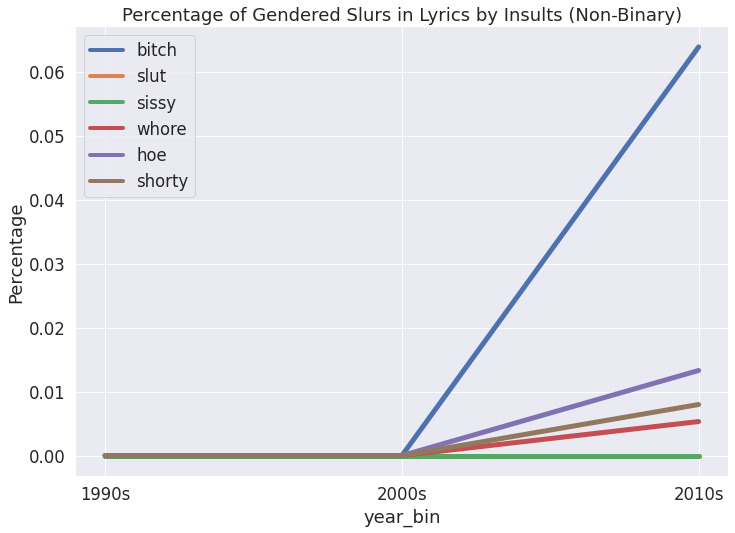

In [ ]:
non_binary = gendered.loc[gendered.gender_matched == 'non-binary'].groupby('year_bin').sum()[['length', 'bitch', 'slut', 'sissy', 'whore', 'hoe', 'shorty']].reset_index()
for q in GENDER_SLURS_:
    non_binary[q] = non_binary[q]/non_binary.length * 100

sns.set(font_scale=1.5)
fig, ax = plt.subplots()
sns.lineplot(x="year_bin", y = "value",hue = 'variable', data = pd.melt(non_binary.drop(columns = 'length'), 'year_bin'), linewidth = 5,\
             color= "tab10").set_title("Percentage of Gendered Slurs in Lyrics by Insults (Non-Binary)")
leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(4.0)
plt.ylabel("Percentage")
plt.savefig("plot/insult_non_bi.png")
plt.show()

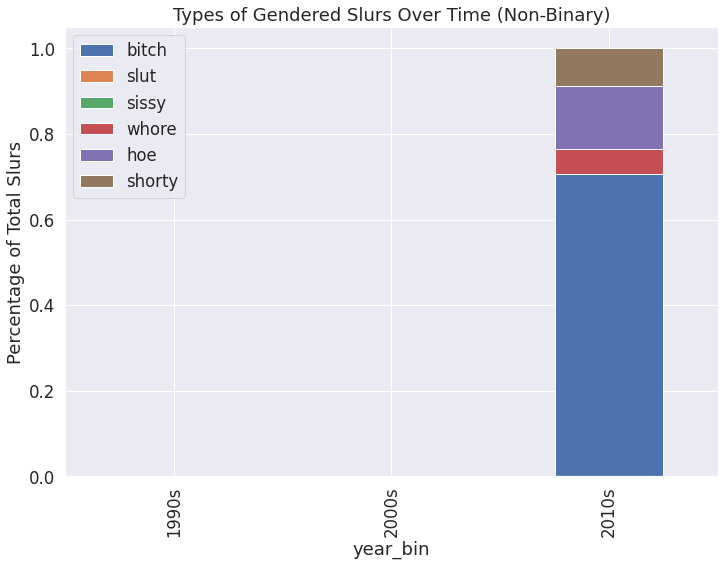

In [ ]:
non_binary = gendered.loc[gendered.gender_matched == 'non-binary'].groupby('year_bin').sum()[['bitch', 'slut', 'sissy', 'whore', 'hoe', 'shorty']].reset_index()
non_binary['total']= non_binary.bitch + non_binary.slut + non_binary.sissy + non_binary.whore + non_binary.hoe + non_binary.shorty
for q in GENDER_SLURS_:
    non_binary[q] = non_binary[q]/non_binary.total 
non_binary = non_binary.drop(columns = ["total"])
sns.set(font_scale=1.5)
non_binary.set_index('year_bin').plot(kind = "bar", stacked = True)
plt.ylabel("Percentage of Total Slurs")
plt.title("Types of Gendered Slurs Over Time (Non-Binary)")
plt.savefig("plot/insult_nb_perc.png")
plt.show()

In [ ]:
!zip -r /content/file.zip /content/plot
from google.colab import files
files.download("/content/file.zip")

  adding: content/plot/ (stored 0%)
  adding: content/plot/insult_female_perc.png (deflated 13%)
  adding: content/plot/perc_insult_male.png (deflated 7%)
  adding: content/plot/perc_slurs.png (deflated 10%)
  adding: content/plot/insult_non_bi.png (deflated 8%)
  adding: content/plot/perc_insult_female.png (deflated 7%)
  adding: content/plot/perc_slurs_gender.png (deflated 7%)
  adding: content/plot/insult_nb_perc.png (deflated 13%)
  adding: content/plot/insult_male_perc.png (deflated 12%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
scnt_dic = {}
for w in GENDER_SLURS:
    cnt_dic[w] = []

In [ ]:
for y in np.unique(cleaned.year_bin).tolist():
    df = year_samp.loc[year_samp.year_bin == y]
    corpus = df.lyrics.sum()
    lyric_tokens = word_tokenize(corpus)
    lyricText = nltk.Text(lyric_tokens)
    for w in GENDER_SLURS:
        cnt = lyricText.count(w)
        print(cnt)
        total_tokens = len(lyric_tokens)
        print(total_tokens)
        cnt_dic[w].append(lyricText.count(w)/len(lyric_tokens))
    print("Finish counting ", y)
    break

38
121079
0
121079
0
121079
0
121079
16
121079
0
121079
0
121079
0
121079
0
121079
Finish counting  1970s


In [ ]:
cnt_dic

{'bitch': [38, 3, 43, 32, 138],
 'ho': [16, 13, 17, 5, 25],
 'hoe': [0, 0, 0, 12, 10],
 'shawty': [0, 0, 0, 4, 4],
 'shorty': [0, 0, 1, 3, 7],
 'sissy': [0, 0, 0, 0, 0],
 'skeezer': [0, 0, 0, 0, 0],
 'slut': [0, 0, 0, 3, 6],
 'whore': [0, 2, 1, 4, 3]}

In [ ]:
year_dic = {}
col = {}
for i, y in enumerate(np.unique(cleaned.year_bin).tolist()):
    col[i] = y

_ = pd.DataFrame(cnt_dic)
for i in range(len(_)):
    year_dic[i] = _.loc[i,:].values

In [ ]:
slurs_df = pd.DataFrame(year_dic)
slurs_df.rename(columns = col)

,1970s,1980s,1990s,2000s,2010s
0,38,3,43,32,138
1,0,0,0,3,6
2,0,0,0,0,0
3,0,2,1,4,3
4,16,13,17,5,25
5,0,0,0,12,10
6,0,0,0,0,0
7,0,0,0,4,4
8,0,0,1,3,7


In [ ]:
slurs_df = pd.DataFrame(cnt_dic)
slurs_df['year_bin'] = np.unique(cleaned.year_bin).tolist()

In [ ]:
slurs_df

,bitch,slut,sissy,whore,ho,hoe,skeezer,shawty,shorty,year_bin
0,38,0,0,0,16,0,0,0,0,1970s
1,3,0,0,2,13,0,0,0,0,1980s
2,43,0,0,1,17,0,0,0,1,1990s
3,32,3,0,4,5,12,0,4,3,2000s
4,138,6,0,3,25,10,0,4,7,2010s


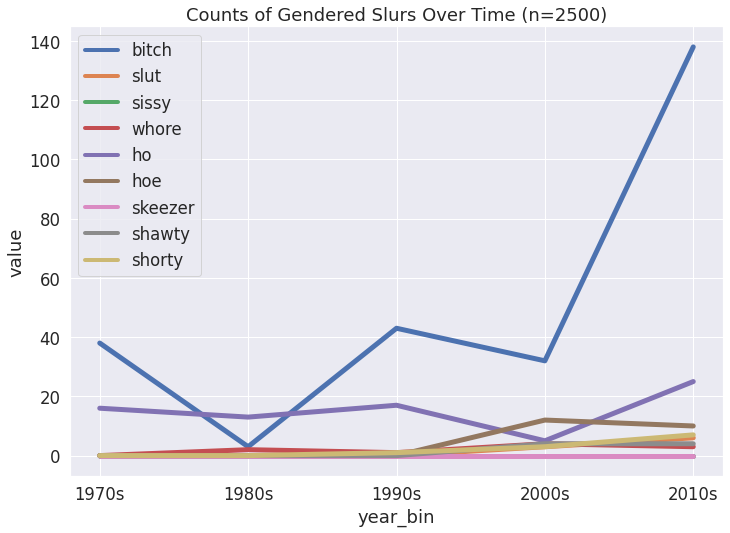

<Figure size 842.4x595.44 with 0 Axes>

In [ ]:
from seaborn.palettes import color_palette
sns.set(font_scale=1.5)
fig, ax = plt.subplots()

sns.lineplot(x="year_bin", y = "value",hue = 'variable', data = pd.melt(slurs_df, 'year_bin'), linewidth = 5,\
             color= "tab10").set_title("Counts of Gendered Slurs Over Time (n=2500)")
leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(4.0)

plt.show()
plt.savefig("count_slurs.png")

## Word Cloud

In [ ]:
import wordcloud

In [ ]:
year_samp['tokenized_text'] = year_samp.lyrics.apply(lambda x: word_tokenize(x.lower()))
year_samp['word_counts'] = year_samp['tokenized_text'].apply(lambda x: len(x))

In [ ]:
countsDict = {}
for word in year_samp['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('i', 29965),
 ('you', 25196),
 ('the', 24570),
 ('to', 14060),
 ('and', 13777),
 ('a', 12822),
 ('it', 11307),
 ('me', 10615),
 ("'s", 9134),
 ("n't", 9107),
 ('my', 8848),
 ('in', 8129),
 ('do', 7080),
 ('that', 6881),
 ('of', 6550),
 ('on', 6198),
 ('your', 5649),
 ("'m", 5548),
 ('we', 5358),
 ('love', 4654)]

In [ ]:
stop_words_freq = []
for word, count in word_counts:
    if word == 'we':
        break
    else:
        stop_words_freq.append(word)
year_samp['normalized_tokens'] = year_samp['tokenized_text'].apply(lambda x: normalizeTokens(x,stop_words_freq))

year_samp['normalized_tokens_count'] = year_samp['normalized_tokens'].apply(lambda x: len(x))

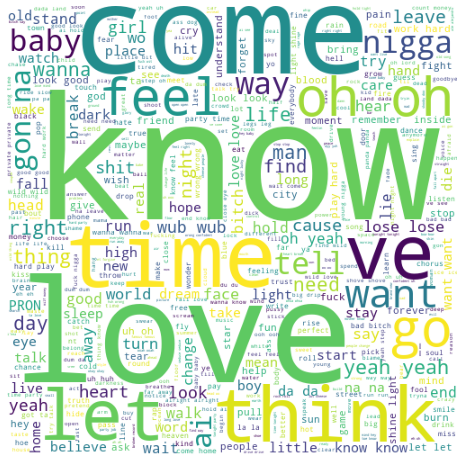

In [ ]:
for y in np.unique(cleaned.year_bin).tolist():
    df = year_samp.loc[year_samp.year_bin == y]
    wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(df['normalized_tokens'].sum()))
    plt.imshow(wc)
    plt.axis("off")
    plt.savefig(f"lyric_wc{y}.pdf", format = 'pdf')

# Segmented Data

In [ ]:
from ast import literal_eval

In [ ]:
df = pd.read_csv("mlm_lyrics.csv", index_col = 0)
df

,title,artist,lyrics,year,popularity,edm,latin,pop,r&b,rap,rock,Gender,year_bin,artist_lower,gender_matched,segmented,song_index
0,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,2012,41.0,False,False,False,True,False,False,Unknown,2010s,ceelo green,0,"[""I really can't stay Baby"", ""it's cold outsid...",0
1,Soldier,James TW,"Hold your breath, don't look down, keep trying...",2019,70.0,False,False,False,True,False,False,Unknown,2010s,james tw,0,"[""Hold your breath, don't look down, keep tryi...",1
2,Satisfy You,Diddy,All I want is somebody who's gonna love me for...,1999,52.0,False,False,False,True,False,False,Unknown,1990s,diddy,0,"[""All I want is somebody who's gonna love me f...",2
3,Changes,2Pac,"I see no changes, wake up in the morning and I...",2007,72.0,False,False,False,False,True,False,Unknown,2000s,2pac,0,"['I see no changes, wake up in the morning', ""...",3
4,Let Me Entertain You - Remastered 2011,Queen,"Hey, it's a sellout! Hey! Let me welcome you, ...",1978,41.0,False,False,False,False,False,True,Unknown,1970s,queen,0,"[""Hey, it's a sellout!"", 'Hey!', 'Let me welco...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37478,Lay Some Happiness On Me,Dean Martin,Lay some happiness on me So the brighter side ...,2014,NaN,False,False,False,False,False,False,Unknown,2010s,dean martin,0,"['Lay some happiness on me', ""So the brighter ...",37478
37479,Baby O,Dean Martin,Baby O You I dig Like a the most Ooh really bi...,2014,NaN,False,False,False,False,False,False,Unknown,2010s,dean martin,0,"['Baby', 'O You', 'I dig Like a the most Ooh r...",37479
37480,Blue Moon,Dean Martin,Blue moon you saw me standing alone Without a ...,2014,NaN,False,False,False,False,False,False,Unknown,2010s,dean martin,0,['Blue moon you saw me standing alone Without ...,37480
37481,Nobody S Baby Again,Dean Martin,People used to call me nobody's baby Up until ...,2014,NaN,False,False,False,False,False,False,Unknown,2010s,dean martin,0,"[""People used to call me nobody's baby Up unti...",37481


In [ ]:
segmented = [literal_eval(x) for x in df.segmented.to_list()]

In [ ]:
df['segmented'] = segmented
df = df.explode('segmented')

In [ ]:
len(df)

1647695

In [ ]:
df.gender_matched.value_counts(normalize=True)

0    0.785884
1    0.202616
2    0.011500
Name: gender_matched, dtype: float64

# Topic Modeling
